# Wind Turbine Fault Detection Study

## Introduction

The field of wind energy has witnessed substantial growth in recent years, with a focus on improving the efficiency and reliability of wind turbine (WT) systems. Fault detection and predictive maintenance have become crucial aspects in ensuring the optimal performance of these systems. In this study, we explore the WT-IIoT dataset made available through on **[Kaggle](https://www.kaggle.com/datasets/wasuratme96/iiot-data-of-wind-turbine)** and originating from the Microsoft Azure Predictive Maintenance Template. The dataset offers a unique opportunity to delve into the intricacies of fault classification based on Supervisory Control and Data Acquisition (SCADA) components, shedding light on potential improvements in predictive maintenance strategies for wind turbines.

## Dataset Overview

The dataset encompasses a range of SCADA measurments taken in the period April 2014-April 2015, providing a comprehensive view of the wind turbine's operational environment. The SCADA variables include essential parameters such as reactive power, blade angle, nacelle position, and temperatures of critical systems, including the bearing, rotor, and stator. Meteorological variables, though limited, encompass minimum, maximum, and average wind speeds. Additionally, the dataset contains status data, which are logs offering insights into the turbine's operating state through variables like main status, sub-status, full status, status Text, Service, FaultMsg.

## Dataset Features

* **Error':** Represents the occurrence of faults in the wind turbine system.

* **'WEC: ava. windspeed', 'WEC: max. windspeed', 'WEC: min. windspeed':** Meteorological variables indicating the availability, maximum, and minimum wind speeds.

* **'WEC: ava. Rotation', 'WEC: max. Rotation', 'WEC: min. Rotation':** Rotation-related variables providing information about the turbine's rotational behavior.

* **'WEC: ava. Power', 'WEC: max. Power', 'WEC: min. Power':** Power-related variables denoting the availability, maximum, and minimum power generated by the wind turbine.

* **'WEC: Operating Hours', 'WEC: Production kWh', 'WEC: Production minutes':** Variables offering insights into the turbine's operating hours and production metrics.

* **'WEC: ava. reactive Power', 'WEC: max. reactive Power', 'WEC: min. reactive Power':** Reactive power-related variables indicating availability, maximum, and minimum reactive power.

* **'WEC: ava. available P from wind', 'WEC: ava. available P technical reasons', 'WEC: ava. Available P force majeure reasons', 'WEC: ava. Available P force external reasons':** Variables categorizing available power based on various factors, such as wind, technical issues, force majeure, and external reasons.

* **'WEC: ava. blade angle A':** Availability of blade angle A, an essential parameter for turbine operation.

* **'Sys 1 inverter 1 cabinet temp.', 'Sys 1 inverter 2 cabinet temp.', ... 'Inverter std dev':** Various temperature-related variables, providing insights into the temperature distribution across different components of the wind turbine.

This study aims to harness these diverse features to develop a robust fault detection model to detect and classify the failures that can arise during wind turbine operation. Our data include the following failure types:

* **Feeding failure 'FF'**: which includes zero crossing in inverters, external shut down of inverters, inverters overload, load shedding in inverters.

* **Excitation failure 'EF'**: correspanding to Overvoltage in DC-link.

* **Main failure 'MF'**: which includes start delay, undervoltage in L1 or L2.

* **Air gap monitoring failure 'AF'**: triggered by sensor 1 in blade C.

* **Generator heating failure 'GF'**: which can happen in Hygrostat inverter or Hygrostat rectifier or Isometer.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
ls ./wind_turbine/

fault_data.csv*  scada_data.csv*  status_data.csv*


In [56]:
fault_data = pd.read_csv("./wind_turbine/fault_data.csv", parse_dates=["DateTime"], index_col="DateTime")
scada_data = pd.read_csv("./wind_turbine/scada_data.csv", parse_dates=["DateTime"], index_col="DateTime")
status_data = pd.read_csv("./wind_turbine/status_data.csv", parse_dates=["Time"], dayfirst=True, index_col="Time")

In [57]:
fault_data.head()

,Time,Fault
DateTime,,
2014-05-14 14:39:44,1.400096e+09,GF
2014-05-14 14:50:24,1.400097e+09,GF
2014-05-14 14:58:56,1.400098e+09,GF
2014-05-14 15:09:36,1.400098e+09,GF
2014-05-14 15:20:16,1.400099e+09,GF


In [58]:
scada_data.head()

,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
DateTime,,,,,,,,,,,,,,,,,,,,,
2014-05-01 00:00:00,1398920448,0,6.9,9.4,2.9,0.0,0.02,0.0,0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
2014-05-01 00:09:00,1398920960,0,5.3,8.9,1.6,0.0,0.01,0.0,0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
2014-05-01 00:20:00,1398921600,0,5.0,9.5,1.4,0.0,0.04,0.0,0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
2014-05-01 00:30:00,1398922240,0,4.4,8.3,1.3,0.0,0.08,0.0,0,0,...,23,21,25,12,14,24,34,2501,25.272728,1.103713
2014-05-01 00:39:00,1398922752,0,5.7,9.7,1.2,0.0,0.05,0.0,0,0,...,23,21,25,12,14,23,34,2501,25.272728,1.103713


In [59]:
status_data.head()

,Main Status,Sub Status,Full Status,Status Text,T,Service,FaultMsg,Value0
Time,,,,,,,,
2014-04-24 12:37:38,0,0,0 : 0,Turbine in operation,1,False,False,7.4
2014-04-25 19:27:24,71,104,71 : 104,Insulation monitoring : Insulation fault Phase U2,6,False,True,20.5
2014-04-26 09:30:13,8,0,8 : 0,Maintenance,6,True,False,17.1
2014-04-26 10:05:19,8,0,8 : 0,Maintenance,6,False,False,8.7
2014-04-26 10:05:25,8,0,8 : 0,Maintenance,6,True,False,10.6


In [60]:
# check datasets sizes
print("Fault data shape:", fault_data.shape)
print("SCADA data shape:", scada_data.shape)
print("Status data shape:", status_data.shape)

Fault data shape: (553, 2)
SCADA data shape: (49027, 65)
Status data shape: (1849, 8)


#### Observation

The fault and status data contains less samples than the total SCADA data because they only include timestamps when a failure actually occured in the wind turbine, so we need to consider that we combining the fault features into the SCADA data.

In [61]:
# check for missing instances
print(f"Fault data missing instances count: {(fault_data.isna().sum()).sum()}")
print(f"SCADA data missing instances count: {(scada_data.isna().sum()).sum()}")
print(f"Status data missing instances count: {(status_data.isna().sum()).sum()}")

Fault data missing instances count: 0
SCADA data missing instances count: 0
Status data missing instances count: 0


In [62]:
# check datasets datetime ranges
print(f"Fault data datetime range from {fault_data.index[0]} to {fault_data.index[-1]}")
print(f"SCADA data datetime range from {scada_data.index[0]} to {scada_data.index[-1]}")
print(f"Status data datetime range from {status_data.index[0]} to {status_data.index[-1]}")

Fault data datetime range from 2014-05-14 14:39:44 to 2015-01-15 23:09:20
SCADA data datetime range from 2014-05-01 00:00:00 to 2015-04-09 00:00:00
Status data datetime range from 2014-04-24 12:37:38 to 2015-04-28 22:18:19


#### Observation

The status data is recorded on a larger datetime range compared to the SCADA data, so to combine the status values with the scada and fault datasets we will be forced to drop some of the additional status record that aren't presents in the two other datasets and thus our study datetime range will be from 2014-05-01 00:00:00 to 2015-04-09 00:00:00.

In [63]:
from datetime import datetime

print("Fault data date/time from DateTime:", fault_data.index[0])
print("Fault data date/time from Timestamp:", datetime.fromtimestamp(fault_data["Time"][0]))

Fault data date/time from DateTime: 2014-05-14 14:39:44
Fault data date/time from Timestamp: 2014-05-14 20:39:44


#### Observation

In both the fault and SCADA datasets it seems that the recorded datetime values are lagging 6 hours behind the recorded timestamp, and the status data contains the lagging datetime values. Because the timestamps records seems more accurate between the fault and SCADA datasets will using them as indexes, and we will have to change the status data timestamps later on.

In [64]:
# change the indexes using "TIME" timestamps
# convert to readable datetimes
fault_data.index = fault_data.Time.apply(lambda x: datetime.fromtimestamp(x))
fault_data = fault_data.drop(["Time"], axis=1)

scada_data.index = scada_data.Time.apply(lambda x: datetime.fromtimestamp(x))
scada_data = scada_data.drop(["Time"], axis=1)

In [65]:
# Check if there are missing values
print("Missing values in Fault data:", (fault_data.isna().sum()).sum())
print("Missing values in SCADA data:", (scada_data.isna().sum()).sum())
print("Missing values in Status data:", (status_data.isna().sum()).sum())

Missing values in Fault data: 0
Missing values in SCADA data: 0
Missing values in Status data: 0


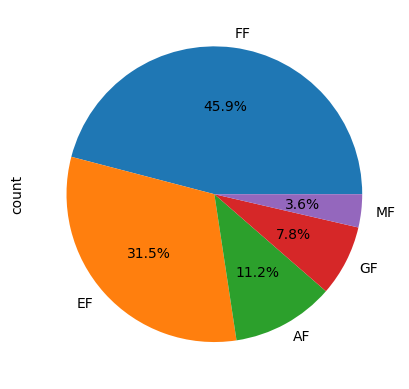

In [66]:
# Check fault classes distribution
_ = fault_data["Fault"].value_counts().plot(kind="pie", autopct='%1.1f%%')

#### Observation

Our data reveals five fault types, with "EF" and "FF" being more prevalent. This suggests that these fault types are likely the most frequently occurring in wind turbines. On the other hand, "MF," "GF," and "AF" faults are less prominent, indicating they may be rare or associated with critical failures in wind turbines, occurring only in extreme situations.

In [67]:
#Check for duplicated datetimes
print("Duplicated datetimes in Fault data:", (fault_data.index.duplicated()).sum())
print("Duplicated datetimes in SCADA data:", (scada_data.index.duplicated()).sum())
print("Duplicated datetimes in Status data:", (status_data.index.duplicated()).sum())

Duplicated datetimes in Fault data: 107
Duplicated datetimes in SCADA data: 6
Duplicated datetimes in Status data: 34


#### Observation

We observe duplicates in all our datasets, but it's important to note that they carry different significance. In the SCADA data, duplicated records can be easily eliminated. However, in the status and fault data, duplicated datetime records indicate instances when two or more fault types occur simultaneously in the wind turbine. These occurrences are crucial for our study.

To address datetime instances with multiple fault types, we will implement one-hot encoding for each fault type at a given datetime.

In [68]:
# drop duplicated instances in SCADA data
scada_data = scada_data[~scada_data.index.duplicated()]

### Check multiple faults occurances

In [69]:
faults = fault_data.groupby(fault_data.index)['Fault'].apply(lambda x: ','.join(x.astype(str)))
fault_classes = faults.str.get_dummies(sep=',')
fault_classes.set_index(faults.index)
fault_classes.head()

,AF,EF,FF,GF,MF
Time,,,,,
2014-05-14 20:39:44,0,0,0,1,0
2014-05-14 20:50:24,0,0,0,1,0
2014-05-14 20:58:56,0,0,0,1,0
2014-05-14 21:09:36,0,0,0,1,0
2014-05-14 21:20:16,0,0,0,1,0


In [70]:
# check which fault can occurs at the same time
fault_classes.apply(lambda x: f'{x["AF"]}{x["EF"]}{x["FF"]}{x["GF"]}{x["MF"]}', axis=1).value_counts()

00100    159
01100     95
01000     79
10000     50
00010     43
10001     12
00001      8
Name: count, dtype: int64

#### Observation

We observe occurrences where both "EF" and "FF" faults happen simultaneously in the wind turbine, as well as instances when "AF" and "MF" faults can occur simultaneously.

In [71]:
# we consider that all instances not present in fault are normal working conditions (No fault)
fault_column = fault_data[~fault_data.index.duplicated()].reindex(scada_data.index, fill_value="NF")

In [72]:
fault_column["Fault"].value_counts()

Fault
NF    48575
EF      174
FF      159
AF       62
GF       43
MF        8
Name: count, dtype: int64

#### Observation

We see now that the fault classes are highly imbalanced as the non fault class represent 99% of the data, seo for performing a classification task we will have to take a smaller sample for the non fault class and we need to use some rebalancing technique to add failure instances.

### Fault logs from status data

The status data contains the logs recorded during the wind turbine operations which inlude both normal working condition and when a failure occurs, we could considere adding those logs features to our global dataset but for the moment we will only work with fault and SCADA data.

## Exploratory data analysis

In [73]:
# combine fault data with scada data
combined_data = scada_data.merge(fault_column, on="Time", how="left")

In [74]:
combined_data.columns

Index(['Error', 'WEC: ava. windspeed', 'WEC: max. windspeed',
       'WEC: min. windspeed', 'WEC: ava. Rotation', 'WEC: max. Rotation',
       'WEC: min. Rotation', 'WEC: ava. Power', 'WEC: max. Power',
       'WEC: min. Power', 'WEC: ava. Nacel position including cable twisting',
       'WEC: Operating Hours', 'WEC: Production kWh',
       'WEC: Production minutes', 'WEC: ava. reactive Power',
       'WEC: max. reactive Power', 'WEC: min. reactive Power',
       'WEC: ava. available P from wind',
       'WEC: ava. available P technical reasons',
       'WEC: ava. Available P force majeure reasons',
       'WEC: ava. Available P force external reasons',
       'WEC: ava. blade angle A', 'Sys 1 inverter 1 cabinet temp.',
       'Sys 1 inverter 2 cabinet temp.', 'Sys 1 inverter 3 cabinet temp.',
       'Sys 1 inverter 4 cabinet temp.', 'Sys 1 inverter 5 cabinet temp.',
       'Sys 1 inverter 6 cabinet temp.', 'Sys 1 inverter 7 cabinet temp.',
       'Sys 2 inverter 1 cabinet temp.', 'Sys

In [75]:
# rename columns
combined_data.columns = ['Error', 'avg_ws', 'max_ws', 'min_ws', 'avg_rot', 'max_rot','min_rot', 
                         'avg_power', 'max_power', 'min_power', 'avg_Nacel_position', 'Operating Hours', 
                         'Production(kWh)', 'Production(min)', 'avg_reactive_power', 'max_reactive_power', 
                         'min_reactive_power', 'avg_available_power_fw', 'avg_available_power_tr',
                         'avg_available_power_mr', 'avg_available_power_er', 'avg_blade_angle_A', 
                         'temp_inverter11', 'temp_inverter12', 'temp_inverter13', 'temp_inverter14', 
                         'temp_inverter15', 'temp_inverter16', 'temp_inverter17', 'temp_inverter21', 
                         'temp_inverter22', 'temp_inverter23', 'temp_inverter24', 'temp_inverter25', 
                         'temp_inverter26', 'temp_inverter27', 'temp_Spinner','temp_Front_bearing', 
                         'temp_Rear_bearing', 'temp_Pitch_cabinet_blade_A', 'temp_Pitch_cabinet_blade_B',
                         'temp_Pitch_cabinet_blade_C', 'temp_Blade_A', 'temp_Blade_B', 'temp_Blade_C', 
                         'temp_Rotor1', 'temp_Rotor2', 'temp_stator1', 'temp_stator2', 'temp_nacelle_ambient1',
                         'temp_nacelle_ambient2','temp_nacelle', 'temp_nacelle_cabinet', 'temp_main_carrier', 
                         'temp_rectifier_cabinet', 'temp_yaw_inverter_cabinet', 'temp_fan_inverter_cabinet', 
                         'temp_ambient', 'temp_tower', 'temp_control_cabinet', 'temp_Transformer', 'avg_RTU_setpoint1', 
                         'Inverter averages', 'Inverter std dev', 'Fault']

In [76]:
# chech the Error column
combined_data["Error"].value_counts()

Error
0      48722
246      164
10        35
20        18
50        18
90        14
30        13
80         9
70         9
40         9
60         9
100        1
Name: count, dtype: int64

It seems that the Error column also indicates the type of fault that occures in the wind turbine, similair to the classes we've extracted above, so for a classification problem we must remove this column before training the models.

### Power/windspeed/rotation relationship

In [115]:
ws_rot_power_features = combined_data[['avg_ws', 'max_ws', 'min_ws', 'avg_rot', 'max_rot','min_rot', 
                         'avg_power', 'max_power', 'min_power', 'avg_reactive_power', 'max_reactive_power', 
                         'min_reactive_power']]

<Axes: xlabel='Time'>

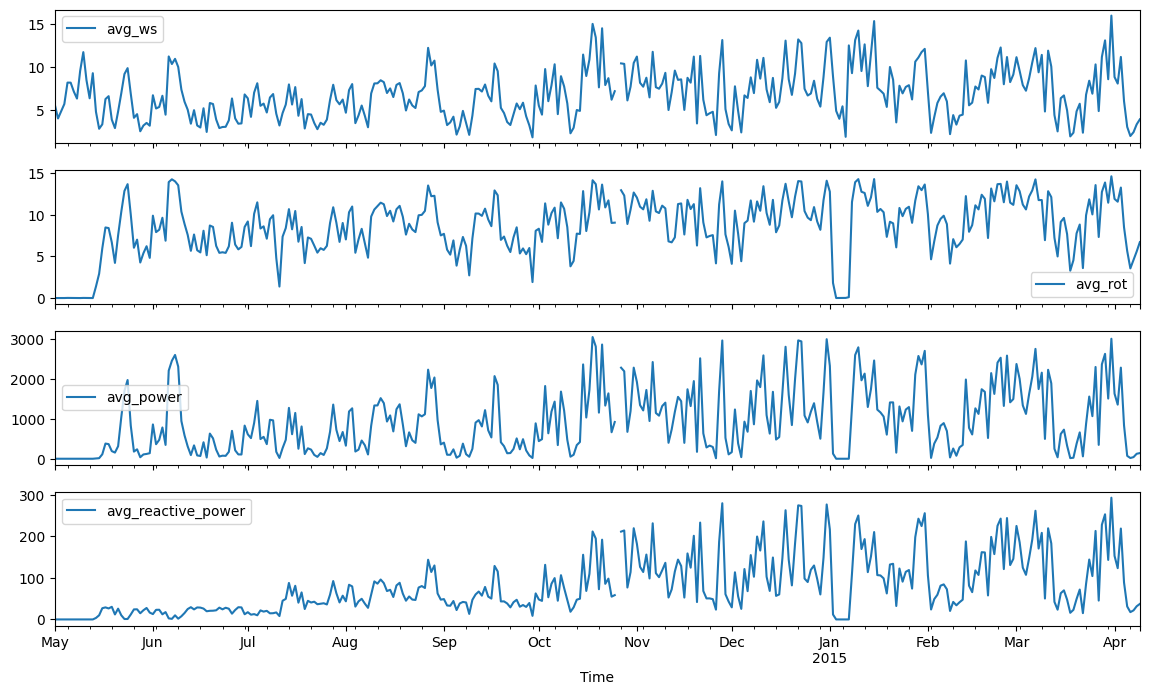

In [117]:
# plot average power, windspeed, rotation
fig, axs = plt.subplots(4, 1, sharex='col', figsize=(14, 8))
ws_rot_power_features.resample('D').mean().plot(y="avg_ws", ax=axs[0])
ws_rot_power_features.resample('D').mean().plot(y="avg_rot", ax=axs[1])
ws_rot_power_features.resample('D').mean().plot(y="avg_power", ax=axs[2])
ws_rot_power_features.resample('D').mean().plot(y="avg_reactive_power", ax=axs[3])

The power generated in a wind turbine is influenced by the rotation speed of its blades, which, in turn, is influenced by the wind speed. This correlation is clearly demonstrated, as the average power, reactive power, blade rotation, and wind speed exhibit synchronous variations.

<Axes: >

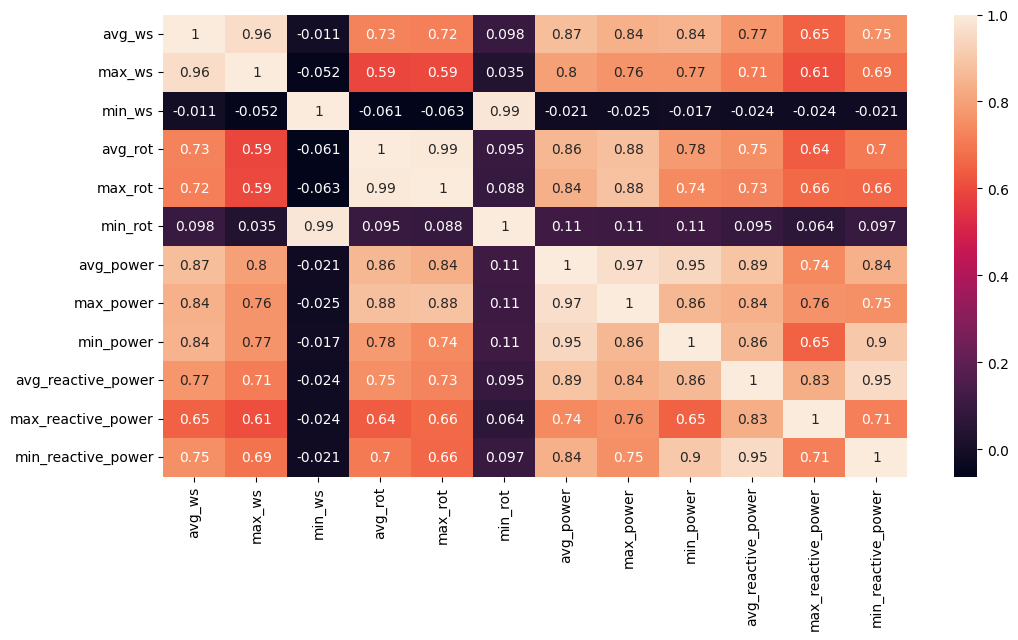

In [121]:
plt.figure(figsize=(12, 6))
sns.heatmap(ws_rot_power_features.corr(), annot=True)

The correlation matrix validates the earlier observation, indicating strong correlations (>60%) among average power, reactive power, blade rotation, and wind speed. Additionally, redundancy is observed in the max measurements, with correlations surpassing 90% when compared to the average measurements, those features should be removed before training the models to optimize the performance.

### Energy production

<Axes: xlabel='Time'>

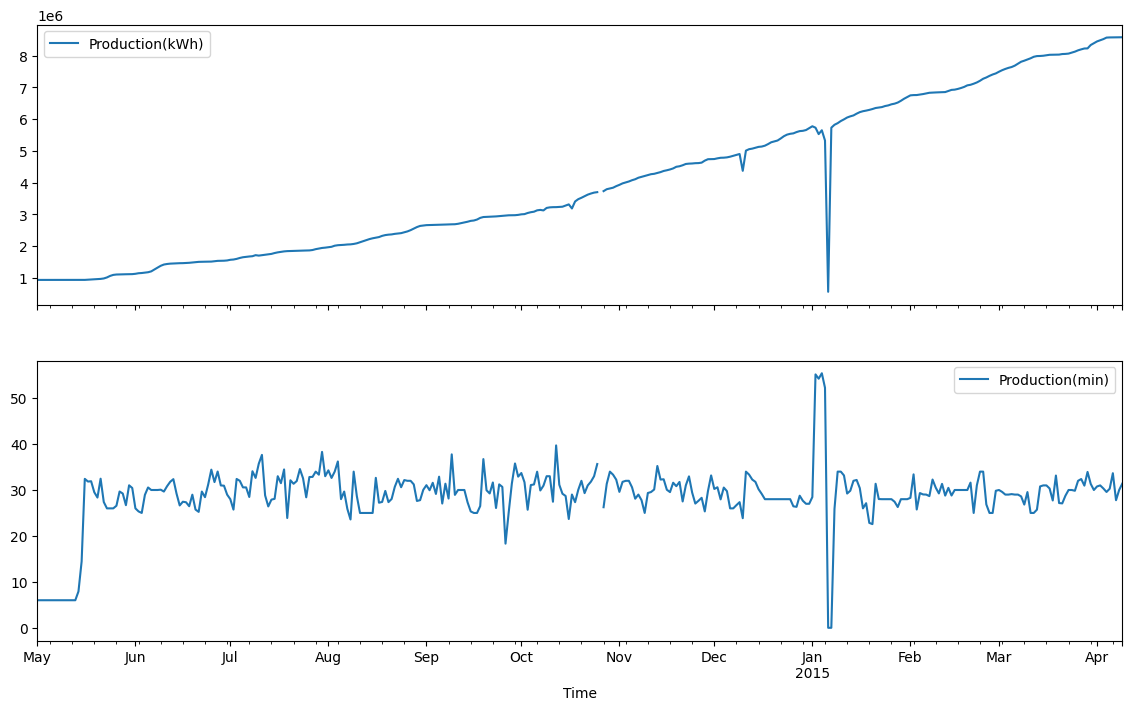

In [207]:
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(14, 8))
combined_data.resample('D').mean(numeric_only=True).plot(y="Production(kWh)", ax=axs[0])
combined_data.resample('D').mean(numeric_only=True).plot(y="Production(min)", ax=axs[1])

We see that there are fluctuations in the total energy (kWh) generated by the turbine, and these variations are attributed to instances of failures. The most prominent occurrence is noted at the beginning of January 2015. This pattern is visually evident in the production minutes plot.

### Energy/Power variation during faults

<Axes: xlabel='Fault', ylabel='Production(kWh)'>

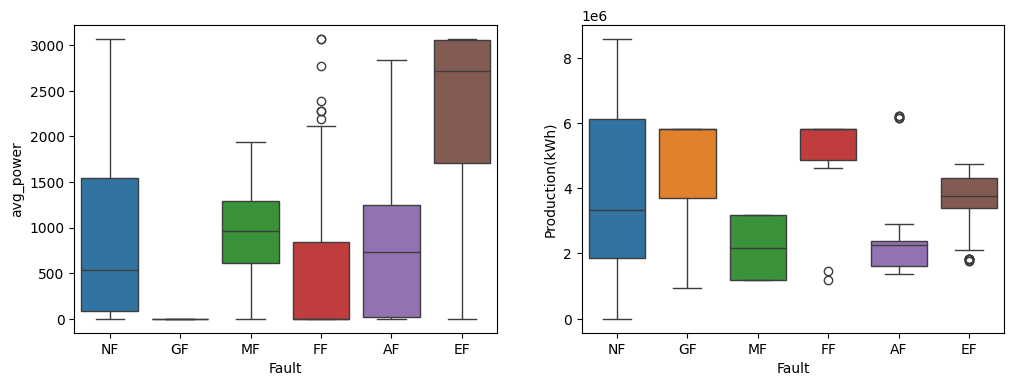

In [114]:
fig, axs = plt.subplots(1, 2, sharex='col', figsize=(12, 4))
sns.boxplot(data=combined_data, y="avg_power", x='Fault', hue='Fault', ax=axs[0])
sns.boxplot(data=combined_data, y="Production(kWh)", x='Fault', hue='Fault', ax=axs[1])

### Temperature features

Let's see the variation in the turbine components temperature during failure situations.

In [135]:
inverters_temperatures = combined_data[['temp_inverter11', 'temp_inverter12', 'temp_inverter13', 'temp_inverter14', 
                         'temp_inverter15', 'temp_inverter16', 'temp_inverter17', 'temp_inverter21', 
                         'temp_inverter22', 'temp_inverter23', 'temp_inverter24', 'temp_inverter25', 
                         'temp_inverter26', 'temp_inverter27', 'Fault']]

In [152]:
invert_temp_by_fault = inverters_temperatures.groupby('Fault').mean().T
df = invert_temp_by_fault.copy()

# Compute temperature percentage change for fault cases compared to non fualt cases
changes_df = df.drop(columns="NF").subtract(df["NF"], axis=0)
temp_percentage_change = changes_df.div(df['NF'], axis=0) * 100
temp_percentage_change['NF'] = invert_temp_by_fault['NF']

temp_percentage_change

Fault,AF,EF,FF,GF,MF,NF
temp_inverter11,17.442523,32.584977,-0.962270,-17.036857,3.376098,26.601894
temp_inverter12,16.872495,29.252866,3.533498,-16.205342,1.644097,27.670077
temp_inverter13,16.246774,27.574963,1.182297,-15.255425,0.458165,27.250149
temp_inverter14,17.007964,27.852773,-1.293770,-20.112003,-0.767452,27.334781
temp_inverter15,16.235319,25.576576,0.249893,-14.374577,-0.878825,28.626577
temp_inverter16,15.763526,23.246217,-4.556181,-19.583533,-1.929078,27.531096
temp_inverter17,13.890380,23.596127,-3.964044,-13.894947,-4.541649,27.629851
temp_inverter21,12.270610,17.270134,-2.745692,-20.298571,-3.847173,29.120309
temp_inverter22,11.753534,17.687787,-1.379856,-15.846496,-4.682454,28.850932
temp_inverter23,10.180473,14.104979,-6.709217,-19.314688,-8.414654,27.842882


We find the following anomalies in from the inverters temperatures: 

- **'AF' and 'EF' Faults:** In these cases, the inverter temperatures exhibit an increase of more than 10% compared to their normal values.

- **'GF' Faults:** During a 'GF' failure, all inverters experience a temperature drop ranging between 14% and 20%.

- **'FF' and 'MF' Faults:** For these faults, the inverter temperatures show a minor percentage change (1% to 10%), either an increase or decrease, depending on the specific inverter, in comparison to their nominal values.

- **Last Three Inverters:** These inverters appear to be operating outside their normal working range. Their temperatures, both nominal and during faults, deviate significantly from those of the other inverters in the system.

<Axes: >

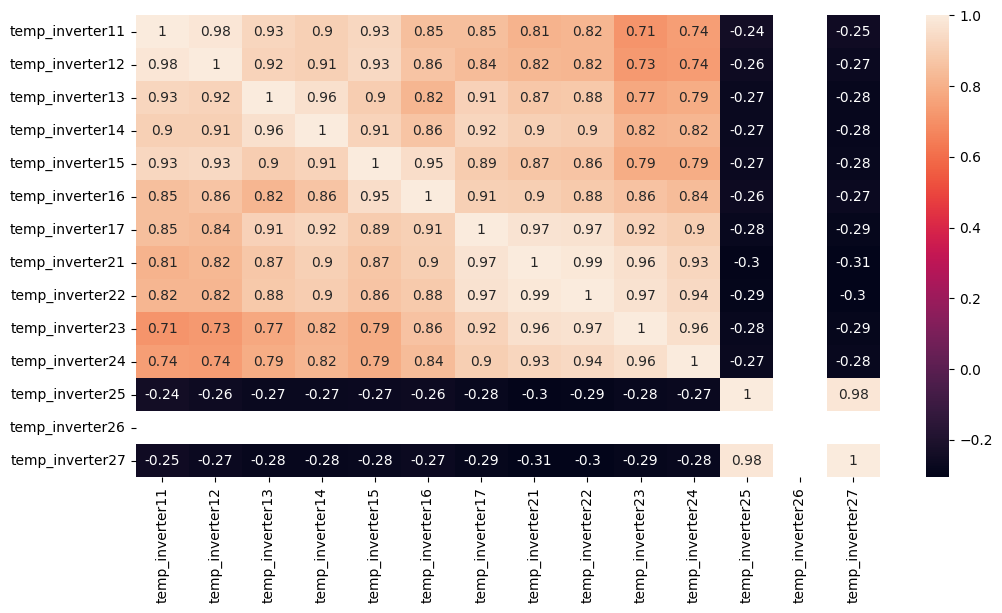

In [208]:
plt.figure(figsize=(12, 6))
sns.heatmap(inverters_temperatures.corr(numeric_only=True), annot=True)

We observe a high correlation among the temperature features of all inverters (excluding the last three inverters), we will consider dropping some of these features when training our models to avoid overfitting due to redundant informations.

In [156]:
# other turbine components temperatures
components_temp = combined_data[['temp_Spinner','temp_Front_bearing', 'temp_Rear_bearing', 'temp_Pitch_cabinet_blade_A', 
                                   'temp_Pitch_cabinet_blade_B', 'temp_Pitch_cabinet_blade_C', 'temp_Blade_A', 'temp_Blade_B', 
                                   'temp_Blade_C', 'temp_Rotor1', 'temp_Rotor2', 'temp_stator1', 'temp_stator2', 
                                   'temp_nacelle_ambient1', 'temp_nacelle_ambient2','temp_nacelle', 'temp_nacelle_cabinet', 
                                   'temp_main_carrier', 'temp_rectifier_cabinet', 'temp_yaw_inverter_cabinet', 
                                   'temp_fan_inverter_cabinet', 'temp_ambient', 'temp_tower', 'temp_control_cabinet', 
                                   'temp_Transformer', 'Fault']]

In [157]:
components_temp_by_fault = components_temp.groupby('Fault').mean().T
df = components_temp_by_fault.copy()

# Compute temperature percentage change for fault cases compared to non fualt cases
changes_df = df.drop(columns="NF").subtract(df["NF"], axis=0)
temp_percentage_change = changes_df.div(df['NF'], axis=0) * 100
temp_percentage_change['NF'] = components_temp_by_fault['NF']

temp_percentage_change

Fault,AF,EF,FF,GF,MF,NF
temp_Spinner,15.500744,7.523793,-16.067093,-29.517518,-4.417058,17.916377
temp_Front_bearing,14.333659,11.226346,-10.691599,-36.124662,-0.287014,22.063325
temp_Rear_bearing,11.219533,10.151042,-10.290091,-31.577297,-0.614532,27.292723
temp_Pitch_cabinet_blade_A,5.836240,8.933801,-4.464683,-10.262881,-7.880631,33.923376
temp_Pitch_cabinet_blade_B,6.524601,7.920736,-5.885780,-9.517654,-7.082383,33.900998
temp_Pitch_cabinet_blade_C,6.000353,7.897623,-7.023424,-9.996346,-6.793213,33.125270
temp_Blade_A,0.306525,0.067590,0.393684,0.485371,0.518791,165.267607
temp_Blade_B,0.256777,0.145486,0.398437,0.615460,0.581969,164.915244
temp_Blade_C,0.236789,0.172208,0.467914,0.526193,0.292779,165.640041
temp_Rotor1,5.802552,91.114254,-13.463478,-34.993587,-1.936851,52.517180


<Axes: >

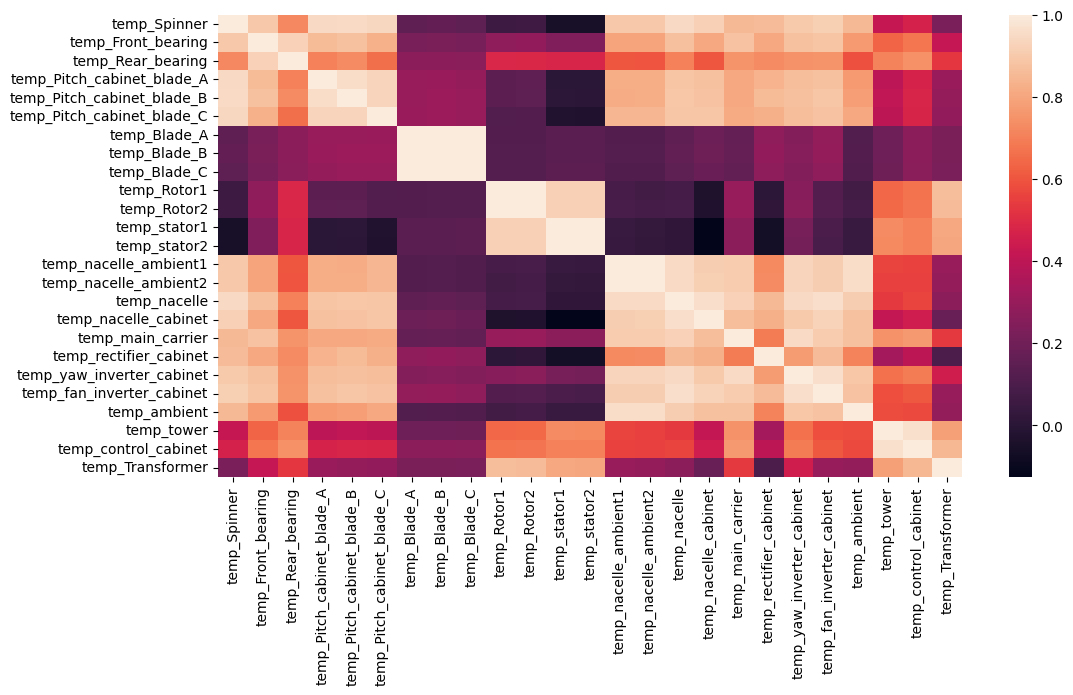

In [160]:
plt.figure(figsize=(12, 6))
sns.heatmap(components_temp.corr(numeric_only=True))

## Data Preprocessing

## Buiding ML models